In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mashlyn/online-retail-ii-uci")

print("Path to dataset files:", path)
print(os.listdir(path))

100%|██████████| 14.5M/14.5M [00:00<00:00, 16.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mashlyn/online-retail-ii-uci/versions/3
['online_retail_II.csv']


## load data

In [3]:
df = pd.read_csv(path + "/online_retail_II.csv")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


cek data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [7]:
for col in df.columns:
    print(f"{col}: {df[col].unique()}")

Invoice: ['489434' '489435' '489436' ... '581585' '581586' '581587']
StockCode: ['85048' '79323P' '79323W' ... '23609' '23617' '23843']
Description: ['15CM CHRISTMAS GLASS BALL 20 LIGHTS' 'PINK CHERRY LIGHTS'
 ' WHITE CHERRY LIGHTS' ... 'mixed up'
 'CREAM HANGING HEART T-LIGHT HOLDER' 'PAPER CRAFT , LITTLE BIRDIE']
Quantity: [    12     48     24 ...    698  80995 -80995]
InvoiceDate: ['2009-12-01 07:45:00' '2009-12-01 07:46:00' '2009-12-01 09:06:00' ...
 '2011-12-09 12:31:00' '2011-12-09 12:49:00' '2011-12-09 12:50:00']
Price: [   6.95    6.75    2.1  ...  933.17 1714.17  224.69]
Customer ID: [13085. 13078. 15362. ... 15520. 13298. 12713.]
Country: ['United Kingdom' 'France' 'USA' 'Belgium' 'Australia' 'EIRE' 'Germany'
 'Portugal' 'Japan' 'Denmark' 'Nigeria' 'Netherlands' 'Poland' 'Spain'
 'Channel Islands' 'Italy' 'Cyprus' 'Greece' 'Norway' 'Austria' 'Sweden'
 'United Arab Emirates' 'Finland' 'Switzerland' 'Unspecified' 'Malta'
 'Bahrain' 'RSA' 'Bermuda' 'Hong Kong' 'Singapore' 'Thai

## feature engineer

mapping country

In [11]:
df['Country'] = df['Country'].apply(lambda x: 'UK' if x == 'United Kingdom' else 'Non-UK')
df.Country.value_counts()

,count
Country,
UK,981330
Non-UK,86041


drop Customer ID null

In [13]:
df.dropna(subset=['Customer ID'], inplace=True)
df.reset_index(drop=True, inplace=True)

clean Quantity <= 0


In [15]:
df = df[df['Quantity'] > 0]
df.reset_index(drop=True, inplace=True)

clean Price <= 0

In [16]:
df = df[df['Price'] > 0]
df.reset_index(drop=True, inplace=True)

convert datetime

In [23]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

reference date

In [24]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

RFM table

In [25]:
recency = (
    df.groupby('Customer ID')['InvoiceDate']
      .max()
      .apply(lambda x: (reference_date - x).days)
)

In [26]:
frequency = (
    df.groupby('Customer ID')['Invoice']
      .nunique()
)

In [27]:
df['TotalPrice'] = df['Quantity'] * df['Price']

monetary = (
    df.groupby('Customer ID')['TotalPrice']
      .sum()
)

In [28]:
rfm = pd.concat([recency, frequency, monetary], axis=1)
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [30]:
rfm.sort_values('Monetary', ascending=False).head()
rfm.sort_values('Frequency', ascending=False).head()
rfm.sort_values('Recency').head()

,Recency,Frequency,Monetary
Customer ID,,,
17581.0,1,43,18757.75
17243.0,1,69,20889.86
12423.0,1,10,2622.39
13521.0,1,3,1093.65
13777.0,1,61,56478.42


cek data akhir df n rfm

In [31]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5878 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    5878 non-null   int64  
 1   Frequency  5878 non-null   int64  
 2   Monetary   5878 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 183.7 KB


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 805549 entries, 0 to 805548
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      805549 non-null  object        
 1   StockCode    805549 non-null  object        
 2   Description  805549 non-null  object        
 3   Quantity     805549 non-null  int64         
 4   InvoiceDate  805549 non-null  datetime64[ns]
 5   Price        805549 non-null  float64       
 6   Customer ID  805549 non-null  float64       
 7   Country      805549 non-null  object        
 8   TotalPrice   805549 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 55.3+ MB


## EDA

#### EDA df

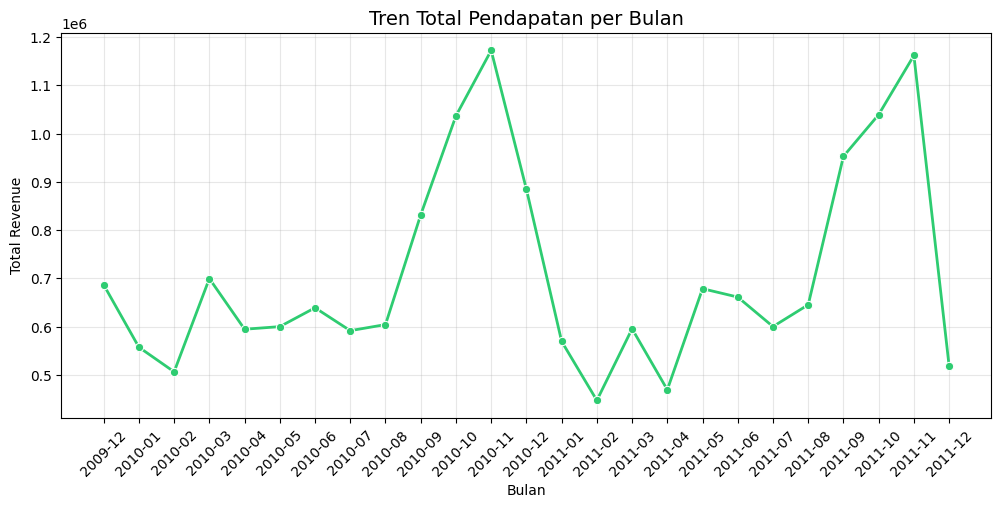

In [36]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
df['Hour'] = df['InvoiceDate'].dt.hour
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

plt.figure(figsize=(12, 5))
monthly_sales = df.groupby('Month')['TotalPrice'].sum()
monthly_sales.index = monthly_sales.index.astype(str)

sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, marker='o', linewidth=2, color='#2ecc71')
plt.title('Tren Total Pendapatan per Bulan', fontsize=14)
plt.xlabel('Bulan')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

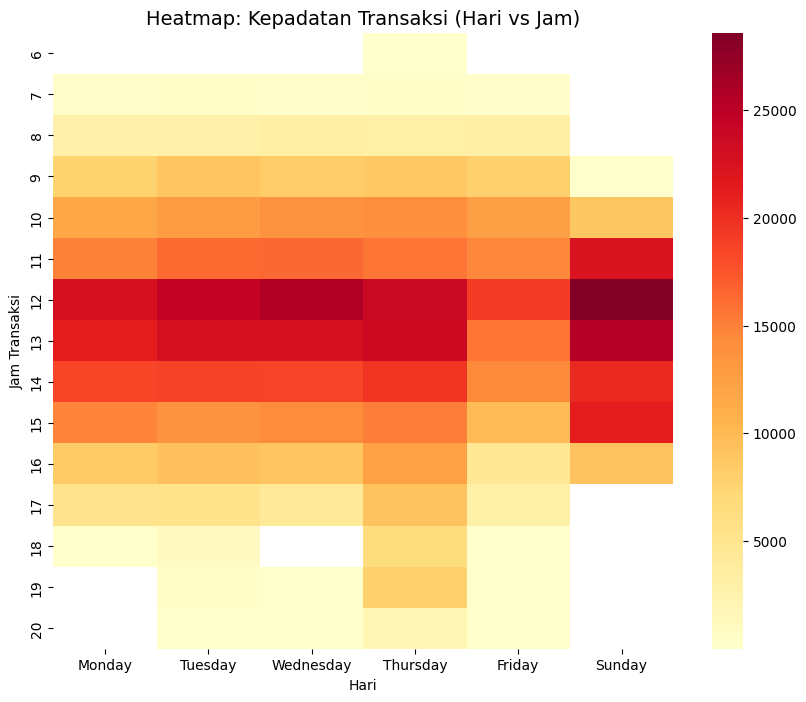

In [37]:
pivot_time = df.pivot_table(index='Hour', columns='DayOfWeek',
                                  values='Invoice', aggfunc='count')

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday']
pivot_time = pivot_time.reindex(columns=days_order)

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_time, cmap='YlOrRd', annot=False, fmt='.0f')
plt.title('Heatmap: Kepadatan Transaksi (Hari vs Jam)', fontsize=14)
plt.xlabel('Hari')
plt.ylabel('Jam Transaksi')
plt.show()

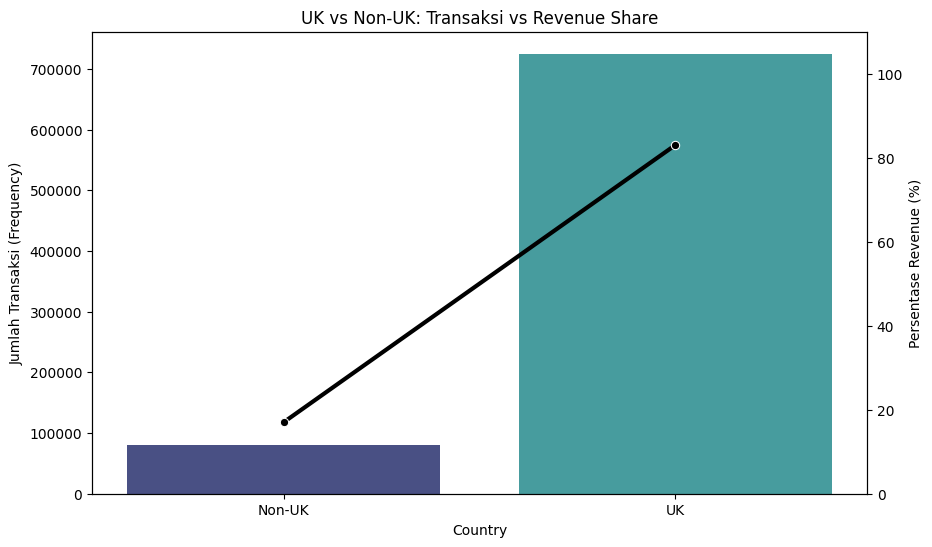

In [43]:
region_stats = df.groupby('Country')['TotalPrice'].agg(['sum', 'count']).reset_index()
region_stats['Share_Revenue'] = region_stats['sum'] / region_stats['sum'].sum() * 100

fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(data=region_stats, x='Country', y='count', ax=ax1, palette='mako')
ax1.set_ylabel('Jumlah Transaksi (Frequency)', color='black')

ax2 = ax1.twinx()
sns.lineplot(data=region_stats, x='Country', y='Share_Revenue', ax=ax2, marker='o', color='black', linewidth=3)
ax2.set_ylabel('Persentase Revenue (%)', color='black')
ax2.set_ylim(0, 110)

plt.title('UK vs Non-UK: Transaksi vs Revenue Share')
plt.show()

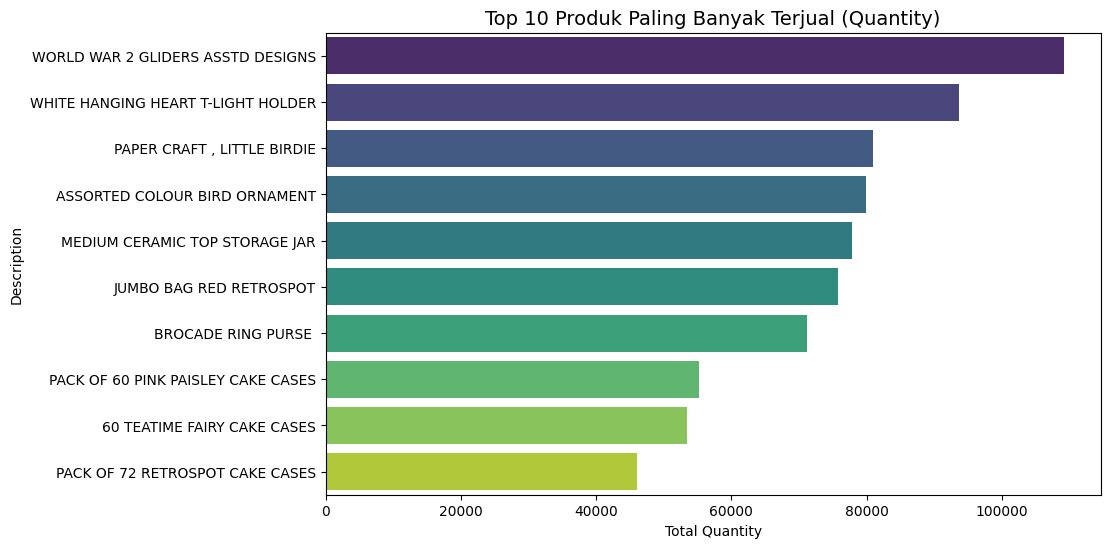

In [45]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Produk Paling Banyak Terjual (Quantity)', fontsize=14)
plt.xlabel('Total Quantity')
plt.show()

#### EDA RFM

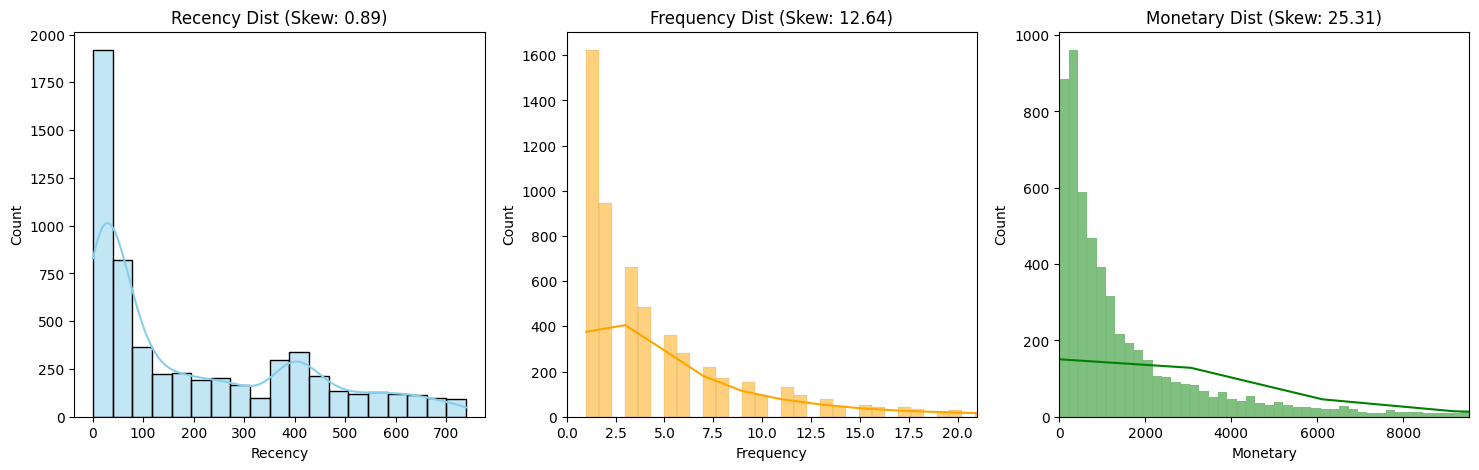

In [49]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title(f"Recency Dist (Skew: {rfm['Recency'].skew():.2f})")

sns.histplot(rfm['Frequency'], kde=True, ax=ax[1], color='orange')
ax[1].set_title(f"Frequency Dist (Skew: {rfm['Frequency'].skew():.2f})")
ax[1].set_xlim(0, rfm['Frequency'].quantile(0.95))

sns.histplot(rfm['Monetary'], kde=True, ax=ax[2], color='green')
ax[2].set_title(f"Monetary Dist (Skew: {rfm['Monetary'].skew():.2f})")
ax[2].set_xlim(0, rfm['Monetary'].quantile(0.95))

plt.show()

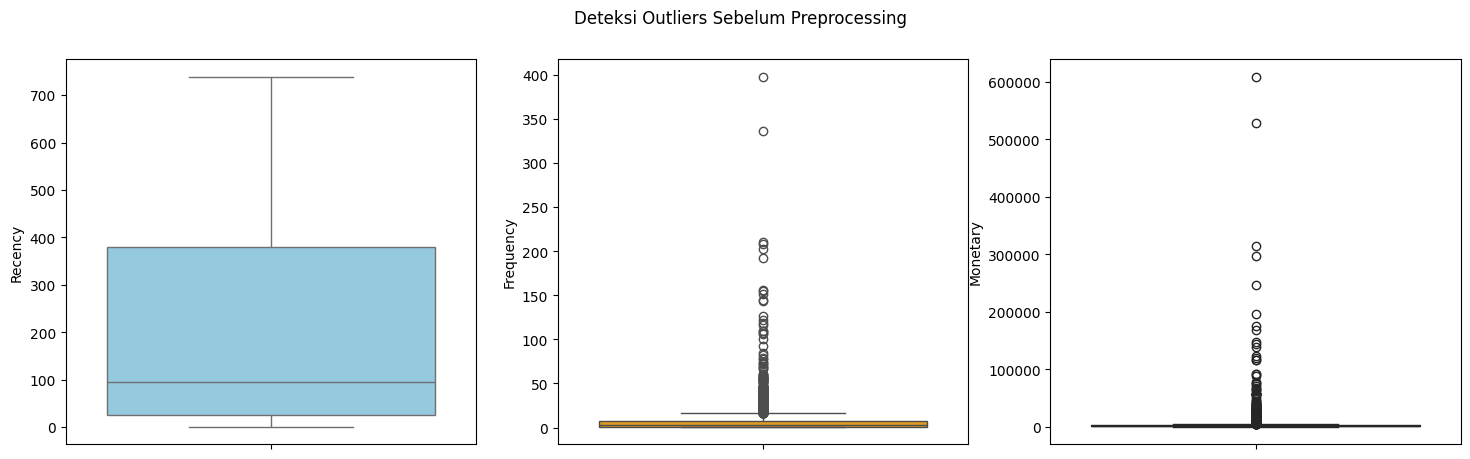

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(y=rfm['Recency'], ax=ax[0], color='skyblue')
sns.boxplot(y=rfm['Frequency'], ax=ax[1], color='orange')
sns.boxplot(y=rfm['Monetary'], ax=ax[2], color='green')
plt.suptitle('Deteksi Outliers Sebelum Preprocessing')
plt.show()

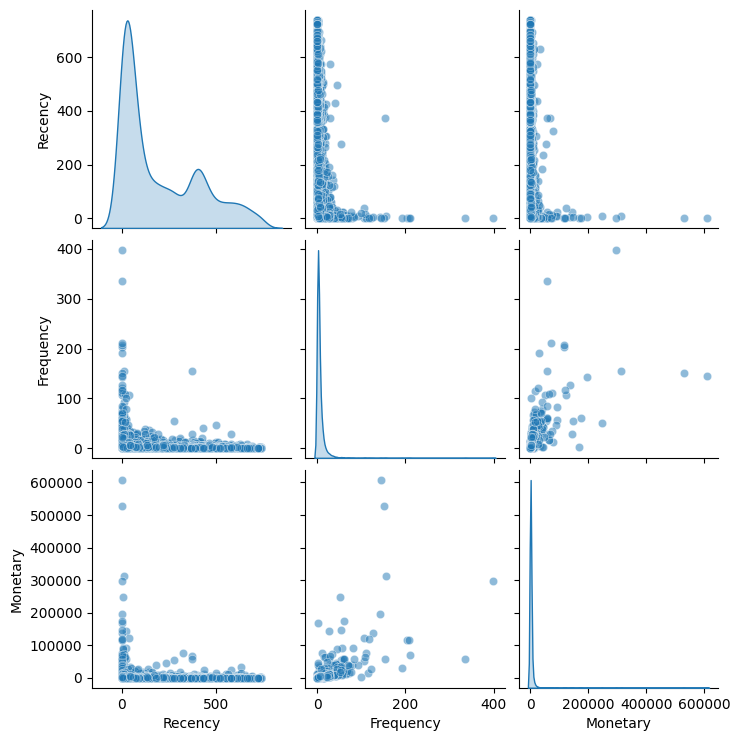

In [52]:
sns.pairplot(rfm, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

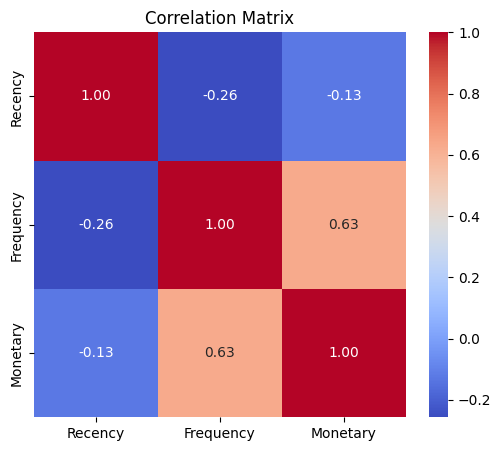

In [53]:
plt.figure(figsize=(6, 5))
sns.heatmap(rfm.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

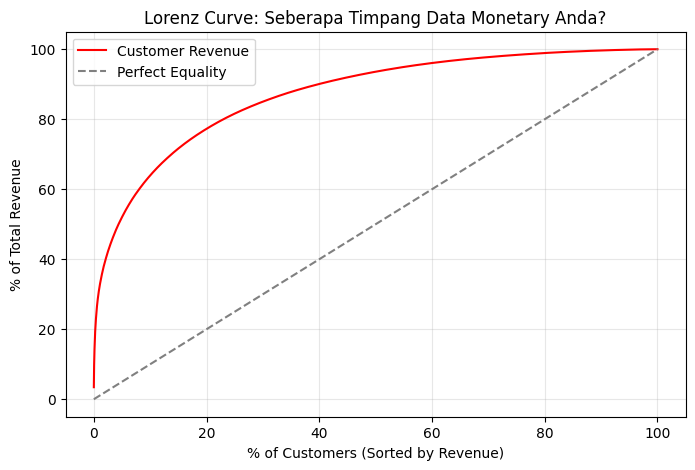

In [58]:
#Kontribusi Top 1% Customer
df_sorted = rfm.sort_values('Monetary', ascending=False)
top_1_percent_cutoff = int(len(df_sorted) * 0.01)

total_revenue = df_sorted['Monetary'].sum()
top_1_revenue = df_sorted.iloc[:top_1_percent_cutoff]['Monetary'].sum()

#One-time buyers vs Loyalists
count_freq_1 = len(rfm[rfm['Frequency'] == 1])
count_freq_100 = len(rfm[rfm['Frequency'] > 100])

cum_cust = np.linspace(0, 100, len(df_sorted))
cum_rev = df_sorted['Monetary'].cumsum() / total_revenue * 100

plt.figure(figsize=(8, 5))
plt.plot(cum_cust, cum_rev, color='red', label='Customer Revenue')
plt.plot([0, 100], [0, 100], color='gray', linestyle='--', label='Perfect Equality')
plt.title('Lorenz Curve: Seberapa Timpang Data Monetary Anda?')
plt.xlabel('% of Customers (Sorted by Revenue)')
plt.ylabel('% of Total Revenue')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Scaling Diagnosis

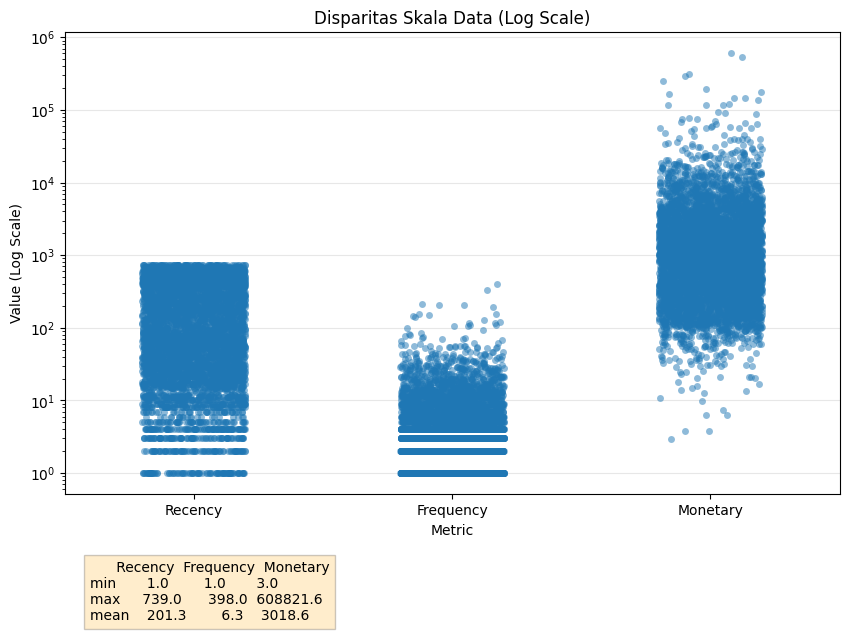

In [59]:
df_melted = rfm.melt(var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.stripplot(x='Metric', y='Value', data=df_melted, jitter=0.2, alpha=0.5)
plt.yscale('log')
plt.title('Disparitas Skala Data (Log Scale)')
plt.ylabel('Value (Log Scale)')
plt.grid(True, axis='y', alpha=0.3)

stats = rfm.describe().loc[['min', 'max', 'mean']]
table_text = str(stats.round(1))
plt.figtext(0.15, -0.1, table_text, fontsize=10, bbox={"facecolor":"orange", "alpha":0.2})

plt.show()

Business Sanity Check

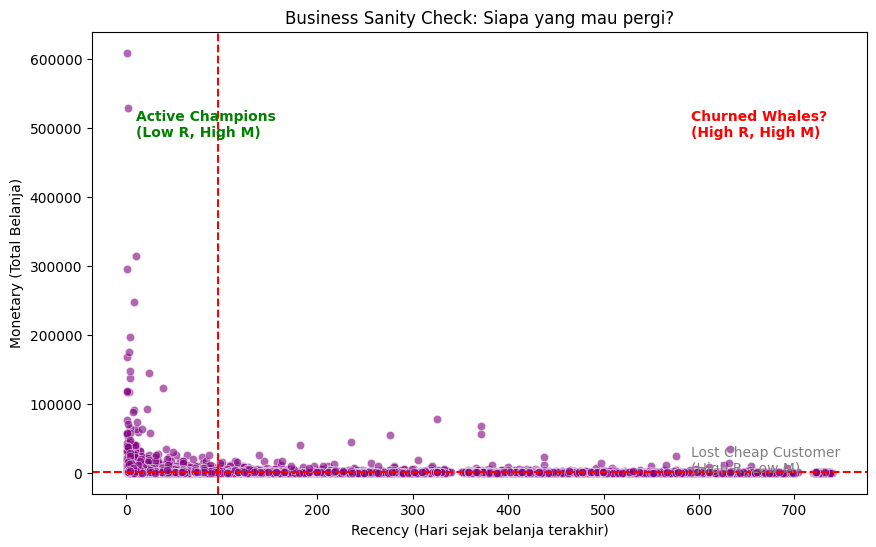

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', alpha=0.6, color='purple')

plt.axvline(rfm['Recency'].median(), color='red', linestyle='--')
plt.axhline(rfm['Monetary'].median(), color='red', linestyle='--')

plt.text(rfm['Recency'].max()*0.8, rfm['Monetary'].max()*0.8, 'Churned Whales?\n(High R, High M)', color='red', fontweight='bold')
plt.text(10, rfm['Monetary'].max()*0.8, 'Active Champions\n(Low R, High M)', color='green', fontweight='bold')
plt.text(rfm['Recency'].max()*0.8, 0, 'Lost Cheap Customer\n(High R, Low M)', color='gray')

plt.title('Business Sanity Check: Siapa yang mau pergi?')
plt.xlabel('Recency (Hari sejak belanja terakhir)')
plt.ylabel('Monetary (Total Belanja)')
plt.show()

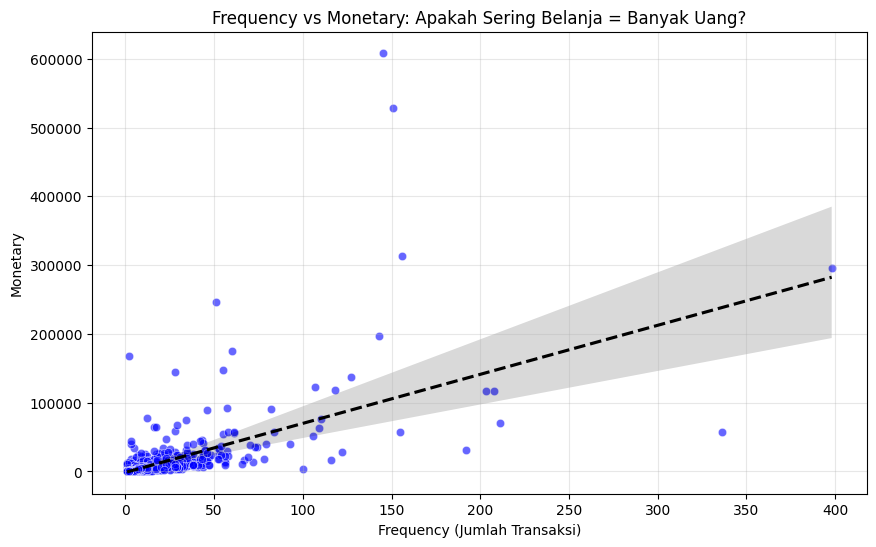

In [61]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', alpha=0.6, color='blue')

sns.regplot(data=rfm, x='Frequency', y='Monetary', scatter=False, color='black', line_kws={'linestyle':'--'})

plt.title('Frequency vs Monetary: Apakah Sering Belanja = Banyak Uang?')
plt.xlabel('Frequency (Jumlah Transaksi)')
plt.ylabel('Monetary')
plt.grid(True, alpha=0.3)
plt.show()

## preprocessing

transform

In [62]:
rfm_transformed = rfm.copy()

rfm_transformed['Recency'] = np.log1p(rfm_transformed['Recency'])
rfm_transformed['Frequency'] = np.log1p(rfm_transformed['Frequency'])
rfm_transformed['Monetary'] = np.log1p(rfm_transformed['Monetary'])

In [63]:
rfm_transformed.skew()

,0
Recency,-0.488631
Frequency,1.001471
Monetary,0.265113


scaler

In [65]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
rfm_scaled = scaler.fit_transform(rfm_transformed)

rfm_scaled = pd.DataFrame(
    rfm_scaled,
    index=rfm.index,
    columns=rfm.columns
)

## KMeans

search k value

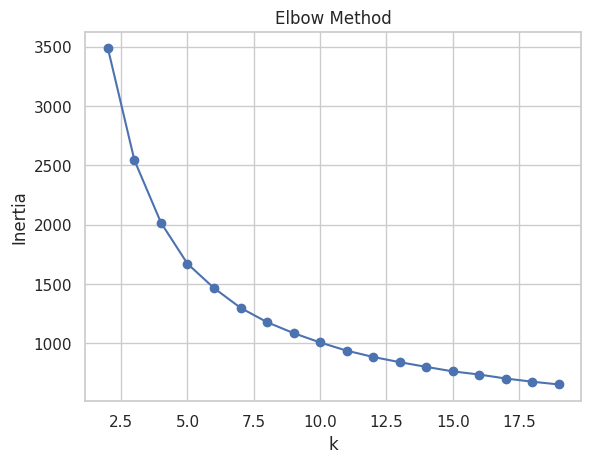

In [69]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(2, 20)

for k in K_range:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

silhouette score

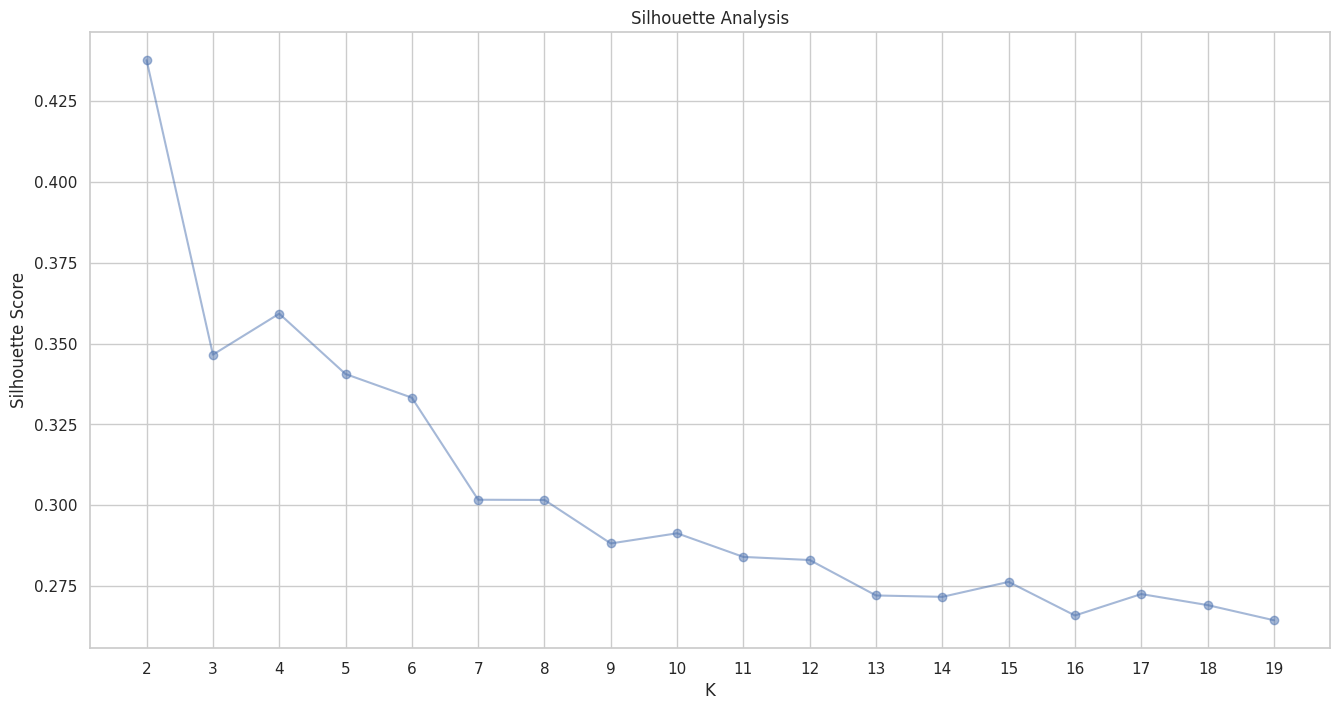

In [71]:
from sklearn.metrics import silhouette_score

sil_scores = []
K_range = range(2, 20)

for k in K_range:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = km.fit_predict(rfm_scaled)
    sil_scores.append(silhouette_score(rfm_scaled, labels))

sns.set(style='whitegrid')
plt.figure(figsize=(16,8))
plt.plot(K_range, sil_scores, 'o-', alpha=0.5)
plt.xlabel('K')
plt.xticks(K_range)
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

k = 4, pca = 2

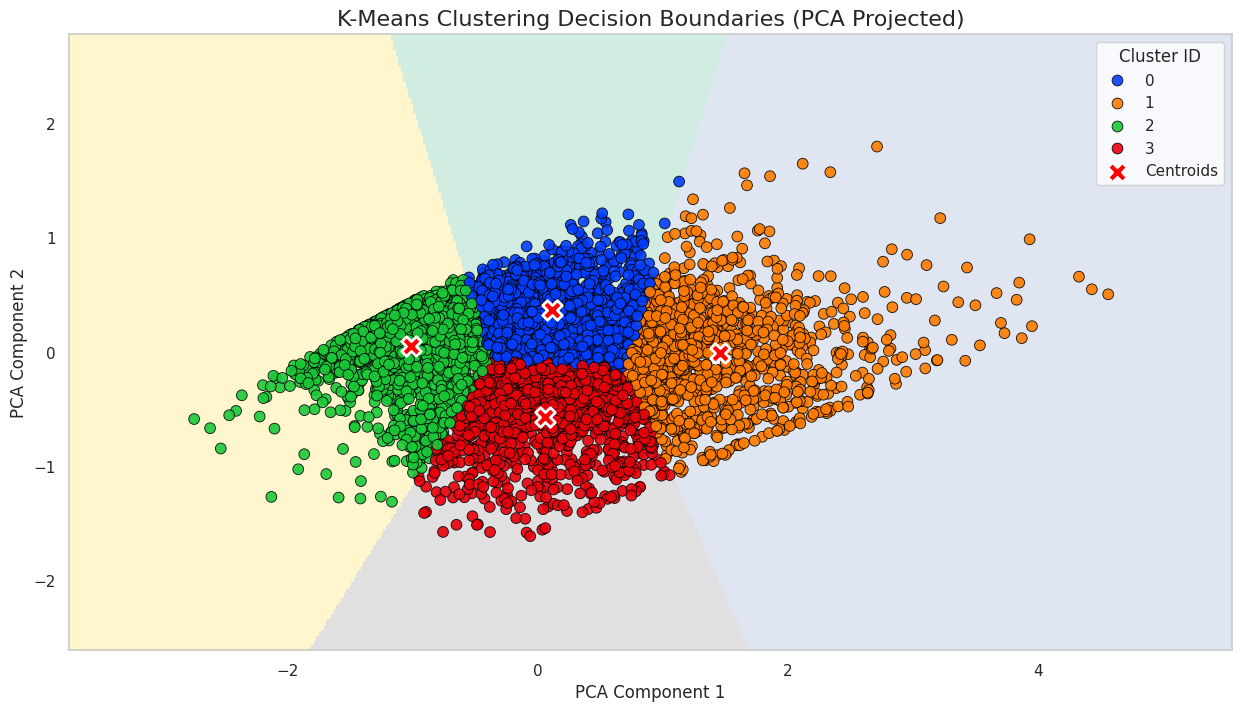

In [85]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(rfm_scaled)

#kmeans
kmeans = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=10,
    random_state=42,
    algorithm='elkan'
)

# fit kmeans
cluster_labels = kmeans.fit_predict(X_pca)
centroids = kmeans.cluster_centers_

rfm['Cluster'] = cluster_labels

df_pca = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
df_pca['Cluster'] = cluster_labels

#plot
h = 0.02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(15, 8))
plt.clf()

plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap='Pastel2',
           aspect='auto',
           origin='lower',
           alpha=0.6)

sns.scatterplot(
    data=df_pca,
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='bright',
    s=60,
    edgecolor='black',
    alpha=0.9
)

plt.scatter(x=centroids[:, 0], y=centroids[:, 1],
            s=200,
            c='red',
            marker='X',
            label='Centroids',
            alpha=1.0,
            edgecolor='white',
            linewidth=2)

plt.title('K-Means Clustering Decision Boundaries (PCA Projected)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Cluster ID', loc='upper right')
plt.grid(False)

plt.show()

In [87]:
rfm_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count'
}).rename(columns={'Cluster': 'Count'})

rfm_summary['Recency'] = rfm_summary['Recency'].astype(int)
rfm_summary['Frequency'] = rfm_summary['Frequency'].astype(int)
rfm_summary['Monetary'] = rfm_summary['Monetary'].astype(int)

rfm_summary

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,235,4,1816,1535
1,29,19,11182,1192
2,384,1,297,1957
3,27,3,874,1194


k = 4, pca 3

In [88]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(rfm_scaled)

print(f"Variance Explained per PC: {pca_3d.explained_variance_ratio_}")
print(f"Total Information Retained: {sum(pca_3d.explained_variance_ratio_) * 100:.2f}%")

#kmeans
kmeans_3d = KMeans(
    n_clusters=4,
    init='k-means++',
    n_init=10,
    random_state=42,
    algorithm='elkan'
)

cluster_labels_3d = kmeans_3d.fit_predict(X_pca_3d)
centroids_3d = kmeans_3d.cluster_centers_

df_pca_3d = pd.DataFrame(data=X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d['Cluster'] = cluster_labels_3d

Variance Explained per PC: [0.77982655 0.17173129 0.04844216]
Total Information Retained: 100.00%


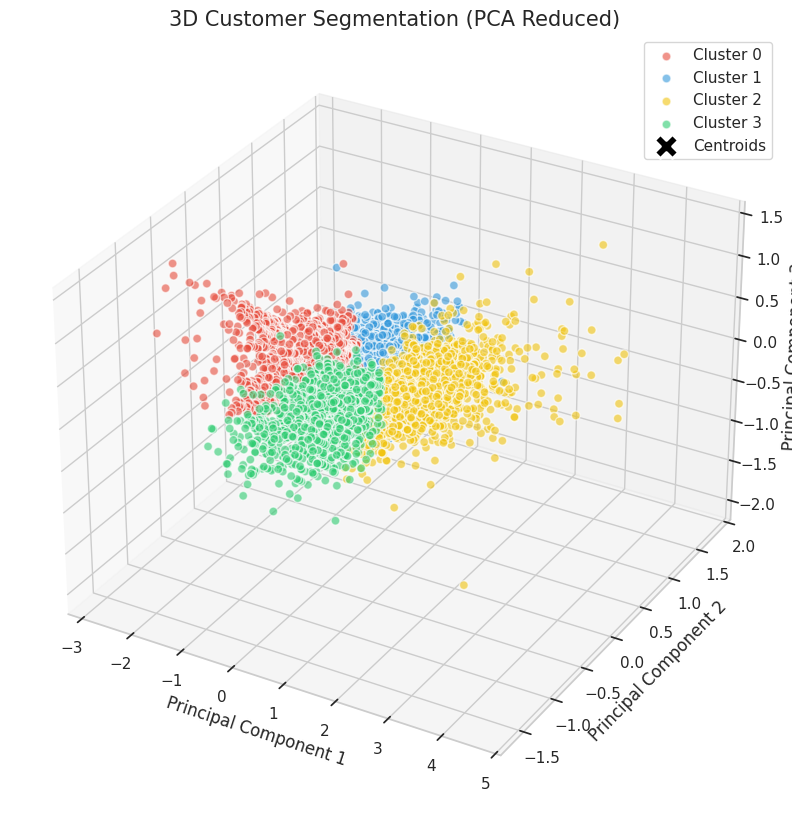

In [89]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['#e74c3c', '#3498db', '#f1c40f', '#2ecc71']

for i in range(4):
    cluster_data = df_pca_3d[df_pca_3d['Cluster'] == i]
    ax.scatter(
        cluster_data['PC1'],
        cluster_data['PC2'],
        cluster_data['PC3'],
        c=colors[i],
        label=f'Cluster {i}',
        s=40,
        alpha=0.6,
        edgecolor='w'
    )

ax.scatter(
    centroids_3d[:, 0],
    centroids_3d[:, 1],
    centroids_3d[:, 2],
    s=300,
    c='black',
    marker='X',
    label='Centroids',
    linewidth=2,
    edgecolor='white'
)

ax.set_title('3D Customer Segmentation (PCA Reduced)', fontsize=15)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()

plt.show()

In [90]:
import plotly.express as px

df_pca_3d['Cluster_Label'] = df_pca_3d['Cluster'].astype(str)

fig = px.scatter_3d(
    df_pca_3d,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster_Label',
    title='Interactive 3D Cluster Visualization',
    opacity=0.7,
    size_max=10,
    color_discrete_sequence=px.colors.qualitative.Bold
)

fig.update_traces(marker=dict(size=4, line=dict(width=0.5, color='DarkSlateGrey')))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=40))

fig.show()